# Import and functions

In [3]:
import os
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import pickle


def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file or 'PORT' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)


def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)


# Function to find corresponding number in another column
def find_corresponding(nums,df_dict):
    return [df_dict[num] for num in nums]

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
#     plt.show()
    plt.close()
    
    
def load_in_paths(pp_file, PP_PATH, DAT_PATH,run_index,ignore_list):
    mir = '_'.join(pp_file.split('_')[0:3])
    print(str(run_index+1) + '/' + str(len(os.listdir(PP_PATH))-1) + '-------------------------------------------------------------------------')
    print(pp_file)
    mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 
    skip = False
    for item in ignore_list:
        if item == mouse_session_recording:
            skip = True

    save_path = PP_PATH + pp_file + '\\_final_analysis_output\\'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    ## set dat_path:
    for file_ in os.listdir(DAT_PATH):
        if mouse_session_recording.split('_')[0] in file_:
            if mouse_session_recording.split('_')[1] == file_[-1]:
                dat_path = os.path.join(DAT_PATH,file_)
    for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
        if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
            dat_path = os.path.join(dat_path,recording)

    # set tracking path
    for file_ in os.listdir(dat_path + r"\video\tracking\\"):
        if 'EJT' in mir:
            if 'task' in file_:
                if not 'clock' in file_:
                    tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
        else:
            tracking_path = dat_path + r"\video\tracking\\"
            

    return mir,mouse_session_recording,save_path,tracking_path,dat_path

                        
# def load_PPSEQ_data(PP_PATH,pp_file,dat_path):

#     # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
#     ## LOAD 
#     print("LOADING PPSEQ DATA")
#     print('\n')
#     #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
#     assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

#     # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
#     latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

#     # seq_type_log_proportions: log p of each type of sequence at each iteration
#     seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

#     # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
#     # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
#     neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")


#     masking = False
#     for dat_files in os.listdir(PP_PATH + pp_file):
#         if 'unmasked_spikes' in dat_files:
#             masking = True
#             print('masking was used')

#     if masking == True:
#         #log_p_hist.csv: the history of the log_p of the model
#         log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

#         unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
#     else:
#         log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

#         spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
#         neuron_ids, spike_times= [], []
#         with open(spikes_file) as f:
#             for (i, line) in enumerate(f.readlines()):
#                 [neuron_id, spike_time] = line.split(' ', 1)
#                 spike_time = eval(spike_time.split('\n')[0])
#                 neuron_id = eval(neuron_id.split('\t')[0])
#                 spike_times.append(spike_time)
#                 neuron_ids.append(neuron_id)
#         unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

#     bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")


#     # Opening JSON file
#     f = open(PP_PATH + pp_file + r'\config_file.json')
#     # returns JSON object as a dictionary
#     config = eval(json.load(f))
#     print(f'      done')

#     ## LOAD behaviour data
#     print('\n')
#     print("LOADING BEHAV DATA")

#     ## load in the timespan used for pppseq:
#     input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
#     # Opening JSON file
#     f = open(input_params_path)
#     # returns JSON object as 
#     # a dictionary
#     input_config = json.load(f)
#     behav_time_interval_start = input_config['time_span']
#     print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")

#     ### load in data:
#     for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
#         if 'task' in sub_file:
#             behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
#     behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
#     transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

#     return assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start

def load_PPSEQ_data(PP_PATH,pp_file,dat_path,mouse_session_recording):

    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    ## LOAD 
    print("LOADING PPSEQ DATA")
    print('\n')
    #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
    assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

    # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
    latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

    # seq_type_log_proportions: log p of each type of sequence at each iteration
    seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

    # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
    # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
    neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")

    masking = False
    for dat_files in os.listdir(PP_PATH + pp_file):
        if 'unmasked_spikes' in dat_files:
            masking = True
            print('masking was used')

    if masking == True:
        #log_p_hist.csv: the history of the log_p of the model
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

        unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
    else:
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

        spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
        neuron_ids, spike_times= [], []
        with open(spikes_file) as f:
            for (i, line) in enumerate(f.readlines()):
                neuron_id, spike_time = line.split('\t')
                spike_time = float(spike_time.strip())
                neuron_id = float(neuron_id)
                spike_times.append(spike_time)
                neuron_ids.append(neuron_id)
        unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 
        bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")

    # Opening JSON file
    f = open(PP_PATH + pp_file + r'\config_file.json')
    # returns JSON object as a dictionary
    config = eval(json.load(f))
    print(f'      done')

    ## LOAD behaviour data
    print('\n')
    print("LOADING BEHAV DATA")

    ## load in the timespan used for pppseq:
    input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
    # Opening JSON file
    f = open(input_params_path)
    # returns JSON object as 
    # a dictionary
    input_config = json.load(f)
    behav_time_interval_start = input_config['time_span']
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")

    ### load in data:
    for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
        if 'task' in sub_file:
            behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
    behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
    transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

    return assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start



def plot_save_log_l_curve(log_p_hist_df,save_path):
    # find 95% of growth value and when it crossed this
    max_ = max(log_p_hist_df.x1)
    min_ = min(log_p_hist_df.x1)
    growth = max_ - min_
    _prcntile =  max_ - (0.02 * growth)

    ## model log likley hood curve
    plt.plot(log_p_hist_df.x1)
    plt.axhline(y=_prcntile, color='r', linestyle='--')

    SaveFig('log_l_curve.png',save_path)
    
def plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, save_path):
    # calculate interval timings and end points
    interval_lengths = []
    for interval in behav_time_interval_start:
        interval_lengths += [np.diff(interval)[0]]
    total_time = sum(interval_lengths)
    interval_end_points = np.cumsum(interval_lengths)

    # Plot sequences - basic
    timeframe = [0, total_time]
    mask = (spikes_df.timestamp > timeframe[0]) * (spikes_df.timestamp < timeframe[-1])

    # Define neuron order
    neuron_permute_loc = np.zeros(len(neuron_index))
    for i in range(len(neuron_index)):
        neuron_permute_loc[i] = int(list(neuron_index).index(i))
    neuron_order = neuron_permute_loc[(spikes_df.neuron - 1).astype(int)]

    # Plotting
    fig, [ax, ax2] = plt.subplots(2, 1, figsize=(20, 20))

    # Plot background in grey
    background_keep_mask = (spikes_df[mask].sequence_type_adjusted < 0) | (spikes_df[mask].sequence_type_adjusted >= 7.0)
    ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
               marker='o', s=40, linewidth=0, color='lightgrey', alpha=0.3)
    c_ = np.array(colors)[spikes_df[mask][background_keep_mask].sequence_type_adjusted.values.astype(int)]
    ax2.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
                marker='o', s=40, linewidth=0, color=c_, alpha=0.3)
    ax2.set_title('extra sequences and background only')

    # Plot spikes without background
    background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0) * \
                             (spikes_df[mask].sequence_type_adjusted != 7.0) * \
                             (spikes_df[mask].sequence_type_adjusted != 8.0)
    c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],
               marker='o', s=40, linewidth=0, color=c_, alpha=1)
    ax.set_title('held sequences in color and extra sequences + background in grey')

    for end_p in interval_end_points:
        ax.axvline(x=end_p, color='k')

    # Save the figure
    plt.savefig(save_path)
    plt.show()
    return interval_end_points,neuron_order


def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def split_list(numbers):
    chunks = []
    indices = []
    current_chunk = []
    current_indices = []
    for i, num in enumerate(numbers):
        if num == 0:
            if current_chunk:
                chunks.append(current_chunk)
                indices.append(current_indices)
                current_chunk = []
                current_indices = []
        else:
            current_chunk.append(num)
            current_indices.append(i)
    if current_chunk:
        chunks.append(current_chunk)
        indices.append(current_indices)
    return chunks, indices

def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def catagorize_seqs(real_order,num_dominant_seqs,order):
    
    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = real_order[0:num_dominant_seqs]
        other_ = real_order[num_dominant_seqs::]
    else:
        dominant = real_order
        other_ = []

    amounts = []
    relative_amounts = []
    pair_outcomes = []
    pairs = []
    for sequence in order:
        ordered = 0
        reverse = 0
        repeat = 0
        misordered = 0
        non_to_task = 0
        task_to_non = 0
        other = 0
        for index,element in enumerate(sequence[0:-1]):
            pair = [element,sequence[index+1]]
            outcome = (logic_machine_for_pair_catagorisation(pair,dominant,other_))
            if outcome == 'ordered':
                ordered +=1
            elif outcome == 'reverse':
                reverse +=1
            elif outcome == 'repeat':
                repeat +=1
            elif outcome == 'misordered':
                misordered +=1
            elif outcome == 'task to other':
                task_to_non +=1
            elif outcome == 'other to task':
                non_to_task +=1
            elif outcome == 'other':
                other +=1
            pairs += [pair]
            pair_outcomes += [[outcome]]
        pairs += [[None]]
        pair_outcomes += [[None]]

        relative_amounts += [list(np.array([ordered,reverse,repeat,misordered,non_to_task,task_to_non,other])/(len(sequence)-1))]
        amounts += [[ordered,reverse,repeat,misordered,non_to_task,task_to_non,other]]
        
    return relative_amounts, amounts,pair_outcomes,pairs

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                elif pair[-1] in (dominant + [item]):
                    return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups


def plot_event_transitions(event_transitions,axes,title):
    transitions = list(event_transitions.keys())
    counts = list(event_transitions.values())

    # Create a bar chart
    axes.bar(range(len(transitions)), counts,alpha = 0.5)

    # Set x-axis labels
    labels = [str(transition) for transition in transitions]
    axes.set_xticks(range(len(transitions)), labels, rotation=90)

    # Set y-axis label
    axes.set_ylabel('Normalized Occurrences %')

    # Add title
    axes.set_title('Event Transitions' + title)

def count_event_transitions(event_list):
    
    ### change code so that it sets each dictionary with these pairs a sa starting point! 
    from itertools import product
    numbers = range(1, 7)  # Numbers 1 to 6a
    all_possible_pairs = list(product(numbers, repeat=2))

    transitions = {key: 0 for key in all_possible_pairs}  # Create an empty dictionary with the defined keys
    
    total_transitions = len(event_list) - 1
    
    for i in range(total_transitions):
        current_event = event_list[i]
        next_event = event_list[i + 1]
        transition = (current_event, next_event)
        if transition in transitions:
            transitions[transition] += 1
        else:
            transitions[transition] = 1
    
    normalized_transitions = {}
    for transition, count in transitions.items():
        normalized_count = count / total_transitions * 100
        normalized_transitions[transition] = normalized_count
    
    return normalized_transitions


def normalize_counts_to_percentages(events_dict):
    total_count = sum(events_dict.values())
    normalized_dict = {}

    for event, count in events_dict.items():
        percentage = (count / total_count) * 100
        normalized_dict[event] = percentage

    return normalized_dict

def SaveFig_noclose(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')


# MAIN

1/13-------------------------------------------------------------------------
ap5R_1_1_run_2605025_1136
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[9000, 11000], [12000, 13000]]


100%|████████████████████████████████████████████████████████████████████████████| 863054/863054 [03:36<00:00, 3988.24it/s]


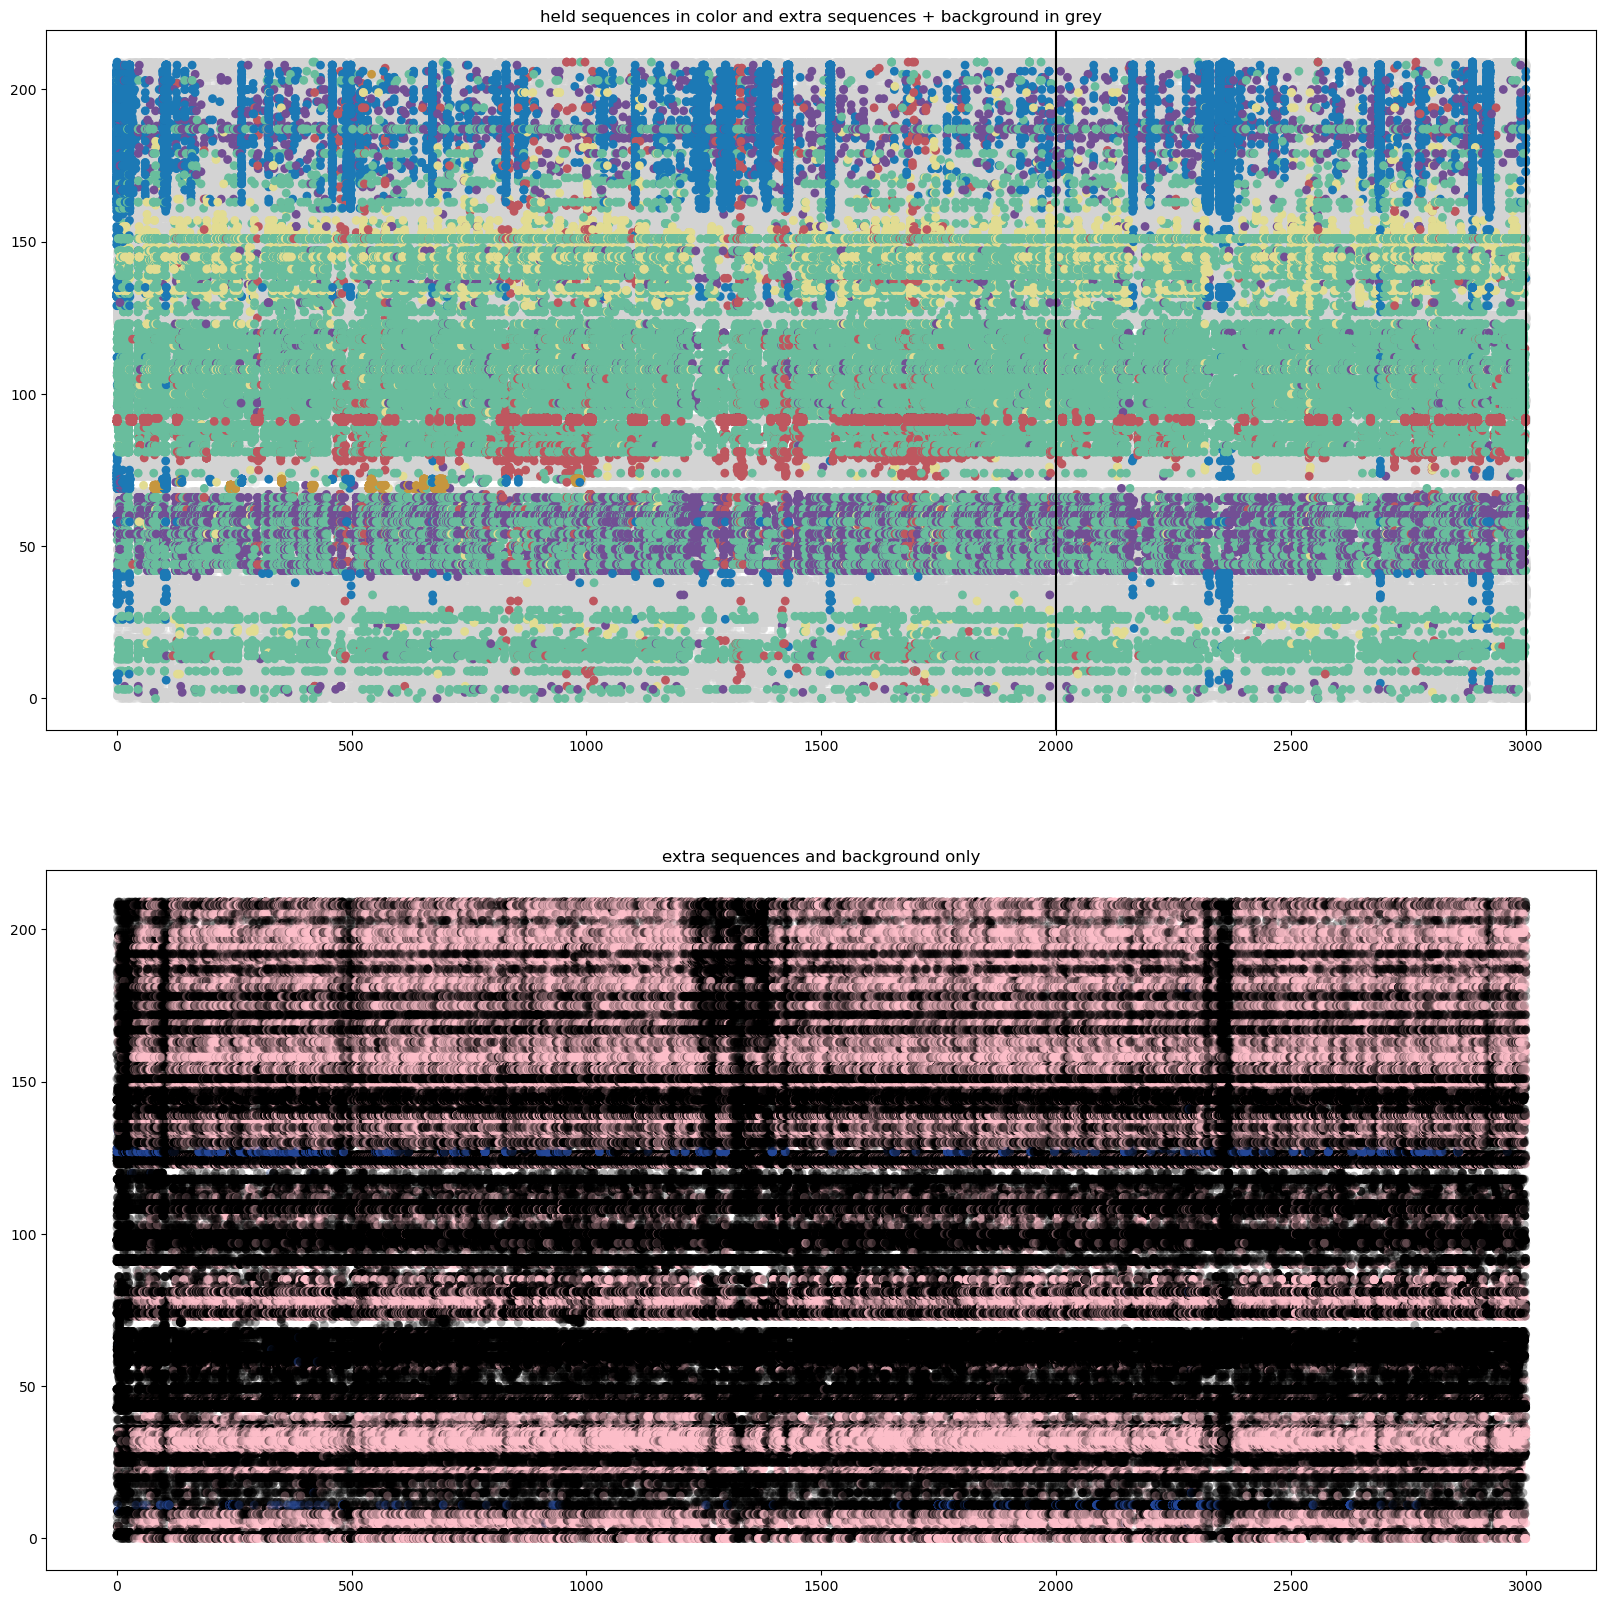

1
2
3
4
5
6


IndexError: index 0 is out of bounds for axis 0 with size 0

In [4]:
## set paths


ignore_list= []
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
# PP_PATH =  "Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\old_data_filter_method\striatum\Medium_pre_sleep\8_seq\\"

# PP_PATH = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\\"

# PP_PATH = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\synthetic_data\non_shuffled\ppseq_output\\"
# DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

PP_PATH = r"Z:\projects\sequence_squad\revision_data\organised_data\ppseq_data\output_data\striatum\Post_sleep\\"
DAT_PATH = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"


# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_post_sleep_shuffle\\"
# PP_PATH = "Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\old_data_filter_method\striatum\Medium_post_sleep\8_seq\\"

######################################################################################################################################################################################################################
# load in data, extract, filter PPseq spikes etc.
# main filtering here:
# backgroudn confidence - spike had to be classified as a seq type 75% of the time across the last 50 iterations to be kept.   
######################################################################################################################################################################################################################

for run_index,pp_file in enumerate(os.listdir(PP_PATH)):
    
#     pp_file= '262_1_4_run_2106023_2357'
    
    if run_index >-1 and 'run' in pp_file:
        # load in paths for that specific mouse and recording
        mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH,run_index,ignore_list)
        
        ## load in PPseq output data
        assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start = load_PPSEQ_data(PP_PATH,pp_file,dat_path,mir)
        # plot out log l curve 
        plot_save_log_l_curve(log_p_hist_df,save_path)
        
    # ---filter_across_itterations---------------------------------------------------------------------------------------------------------------------------------------------------------------    
        # Initialize an empty df to store the result
        seq_types_df = pd.DataFrame()
        # Iterate through the range
        # for iteration_ in tqdm(range(400, 500)):
        for iteration_ in tqdm(range(250, 300)):
            # Extract the relevant column from the assignment history dataframe
            assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]
            # Get the index of the -1 split markers in the latent event history dataframe
            end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
            # Extract the relevant portion of the latent event history dataframe
            latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]
            # Create a dictionary from the dataframe for faster lookups
            df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()
            # Match the sequence ID to the sequence type
            seq_type = find_corresponding(assignment_history_df_split,df_dict)
            # Append the result to the df
            seq_types_df[str(iteration_+1)] = seq_type
        proportion = []
        seq_type = []
        for index in tqdm(range(len(seq_types_df))):
            row = seq_types_df.loc[index]
            seq_type += [statistics.mode(row)] 
            proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]
        # add seq type to dataframe
        unmasked_spikes_df['sequence_type'] = seq_type
        # add seq type to dataframe
        unmasked_spikes_df['seq_confidence'] = proportion
        
        # ## filter for background confidence :-------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        thresh = max(proportion) *.75 ### 
        plt.plot(np.sort(proportion)[::-1])
        plt.axhline(y = thresh, color = 'r', linestyle = '-')
        unmasked_spikes_df['sequence_type_adjusted'] = seq_type
        unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1
        SaveFig('filtering_curve.png',save_path)
        
        ## load in colors and order from awake data -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        found = False
        awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"
        for file_ in os.listdir(awake_PP_path):
            if mouse_session_recording in file_:
                awake_file = file_
                found = True
        if not found:
            awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\awake\\"
            for file_ in os.listdir(awake_PP_path):
                if mouse_session_recording in file_:
                    awake_file = file_
                    found = True

        ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')
        neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
        colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')
        spikes_df = unmasked_spikes_df
        colors += ['pink','lightblue', 'k'] 
        
        ############### plot simple rasters ------------------------------
        interval_end_points,neuron_order = plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, save_path + 'all_data_raster.png')


        ######################################################################################################################################################################################################################
        # filter replays 
        # spikes for each type are binned into 40ms time bins.  ## used to be 20ms - for phd thesis
        # if spikes occur continuously across bins then this is classified as a single contiguous replay event 

        # if at least 5 spikes and 3 neurons were involved its called a replay.

        ######################################################################################################################################################################################################################    
        # TEST - was 5
        min_spikes_filter = 7
        #3
        min_neurons_involved_filter = 5
        bin_size = 0.02

        chunk_paths = []
        # run for each time chunk: 
        for index_,interval_start in enumerate([0] + list(interval_end_points)[0:-1]):

            ## define path for this chunk
            chunk_path = save_path + 'chunk' + str(index_+1)+'_' + str(behav_time_interval_start[index_][0]) + 'to' + str(behav_time_interval_start[index_][1]) + '\\'
            chunk_paths += [chunk_path]
            if not os.path.isdir(chunk_path):
                os.mkdir(chunk_path)

            ## save out time interval for current chunk:
            
            np.save(chunk_path+ 'chunk_time_interval.npy',np.array(behav_time_interval_start[index_]))

            timeframe = [interval_start,interval_end_points[index_]-1]
            total_time = np.diff(timeframe)[0]+1
            #mask
            # spikemask for plotting
            mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])

            fig, [ax1,ax2] = plt.subplots(2, 1,figsize=(35, 15))

            # plot spikes without background
            background_remove_mask = (spikes_df[mask].sequence_type_adjusted > -1) * (spikes_df[mask].sequence_type_adjusted < 7)
            c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
            ax1.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


            # define chunk data:
            chunk_mask = (spikes_df.timestamp > interval_start) * (spikes_df.timestamp < interval_end_points[index_])
            chunk_df = spikes_df[chunk_mask].copy()
            chunk_df = chunk_df.reset_index(drop=True)

#             if not run_index == 16:
            #save out chunk data 
            chunk_df.to_csv(chunk_path + 'unfiltered_spikes_data.csv', index=False)

            ### bin the spiking for each seq type
            seqs = np.unique(chunk_df.sequence_type_adjusted)
            seq_spikes = []
            seq_neurons = []
            for seq_type_ in seqs:  
                seq_spikes += [chunk_df.timestamp[np.where(chunk_df.sequence_type_adjusted ==seq_type_)[0]].values]
                seq_neurons += [chunk_df.neuron[np.where(chunk_df.sequence_type_adjusted ==seq_type_)[0]].values]
            binned_seq_r_events = []
            for spikes_ in seq_spikes:
                # Use the numpy.histogram function to bin the data
                hist, bins = np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))
                binned_seq_r_events += [list(hist)]
            strt_ = int(timeframe[0]/bin_size)
            end_ = int(timeframe[1]/bin_size)   

            # loop over smoothed data for eeahc sew and create cluster chunks from this: 
            r_start_ = []
            r_end_ = []
            r_seq_type = []
            for _index_,sequence_type in enumerate(seqs):
                sequence_type = int(sequence_type)
                # if seq type not background or other new types:
                if sequence_type > 0 and sequence_type <= 6:
                    print(sequence_type)

                    # smooth over binned spikes:
                    smoothed_binned_spikes = convolve_movmean(binned_seq_r_events[_index_],2)

                    # plot smoothed counts for this sequence 
                    time_bins = np.arange(timeframe[0],timeframe[0]+np.diff(timeframe)+1,bin_size)
                    ax2.plot(time_bins[0:-1],smoothed_binned_spikes, c = colors[sequence_type])
                    ax2.sharex(ax1)

                    ## split smoothed replay into single events
                    replay_chunks,indices = split_list(list(smoothed_binned_spikes))

                    for index,chunk in enumerate(replay_chunks):
                        # start and end of chunk event:
                        r_seq_type += [sequence_type]
                        r_start_ += [time_bins[indices[index][0]]]
                        r_end_ += [time_bins[indices[index][-1]]]

            ## perform filtering on cluster chunks
            #filter1 number of spikes
            #filter2 number of neurons 
            filtered_cluster_sequence_type = []
            filtered_cluster_timestamps = []
            filtered_num_spikes = []
            filtered_num_neurons = []
            filtered_first_spike_time = []
            filtered_last_spike_time = []
            filtered_cluster_neurons = []
            event_length = []
            cluster_neuron_order = []
            for i in range(len(r_seq_type)):
                r_event_df = chunk_df[(chunk_df.timestamp >= r_start_[i]) * (chunk_df.timestamp <= r_end_[i])].copy()
                neuron_orders = neuron_order[chunk_mask][(chunk_df.timestamp >= r_start_[i]) * (chunk_df.timestamp <= r_end_[i])]
                # only neurons of the seq type
                neuron_orders = neuron_orders[r_event_df.sequence_type_adjusted == r_seq_type[i]]
                r_event_df = r_event_df[r_event_df.sequence_type_adjusted == r_seq_type[i]]
                if len(r_event_df) > 0:
                    num_spikes = len(r_event_df.sequence_type_adjusted)
                    num_neurons = len(r_event_df.neuron.unique())
                    first_spike = min(r_event_df.timestamp)
                    last_spike = max(r_event_df.timestamp)

                    if num_spikes >= min_spikes_filter:
                        if num_neurons >= min_neurons_involved_filter:
                            ax1.axvspan(first_spike,last_spike, color=colors[r_seq_type[i]], alpha=0.5)
                            ## save replay clusters out!
                            filtered_cluster_sequence_type += [r_seq_type[i]]
                            filtered_cluster_timestamps += [list(r_event_df.timestamp.values)]
                            filtered_cluster_neurons += [list(r_event_df.neuron.values)]
                            filtered_num_spikes += [num_spikes]
                            filtered_num_neurons += [len(r_event_df.neuron.unique())]
                            filtered_first_spike_time += [first_spike]
                            filtered_last_spike_time += [last_spike]
                            event_length += [last_spike-first_spike]
                            cluster_neuron_order += [neuron_orders]

            filtered_r_clusters_df = pd.DataFrame({'cluster_seq_type':filtered_cluster_sequence_type, 'num_spikes':filtered_num_spikes,  'num_neurons': filtered_num_neurons,'first_spike_time':filtered_first_spike_time,'event_length':event_length,'last_spike_time':filtered_last_spike_time, 'cluster_spike_times':filtered_cluster_timestamps,'cluster_neurons':filtered_cluster_neurons,'spike_plotting_order': cluster_neuron_order})
            filtered_r_clusters_df.to_csv(chunk_path + 'filtered_replay_clusters_df.csv', index=False)    

            SaveFig_noclose(mouse_session_recording + 'non_zoomed_data_filtering_chunk_'+ str(index_+1) + '.png',os.path.join(PP_PATH,'quick_view_output/'))
            
            ax1.set_xlim(timeframe[0]+140,timeframe[0]+150)
            ax2.set_xlim(timeframe[0]+140,timeframe[0]+150)

            SaveFig_noclose(mouse_session_recording + 'zoomed_data_filtering_chunk_'+ str(index_+1) + '.png',os.path.join(PP_PATH,'quick_view_output/'))
            SaveFig('zoomed_data_filtering_chunk_'+ str(index_+1) + '.png',chunk_path)
            
            
            
            ######################################################################################################################################################################################################################
            # cluster these events into coactive chunks
            # if events are within 200ms of each other then they are clustered together


            ######################################################################################################################################################################################################################    

            #cluster events
            start_times = filtered_r_clusters_df.first_spike_time.values
            end_times = filtered_r_clusters_df.last_spike_time.values
            event_proximity_filter =  0.2 #s (how close events have to be to each other to be clustered together as coacitve 

            clustered_events = cluster_events(start_times, end_times,event_proximity_filter)


            spike_times = [item for sublist in filtered_r_clusters_df.cluster_spike_times.values for item in sublist]    
            neuron_orders = [item for sublist in filtered_r_clusters_df.spike_plotting_order.values for item in sublist]    

            cst = []
            for index,item in enumerate(filtered_r_clusters_df.cluster_spike_times):
                cst += len(item)*[filtered_r_clusters_df.cluster_seq_type.values[index]]
            c_ = np.array(colors)[np.array(cst)]
            fig, [ax1,ax2] = plt.subplots(2, 1,figsize=(20, 10))

            ax1.scatter(spike_times, neuron_orders,marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
            ax2.scatter(spike_times, neuron_orders,marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

            for i in range(len(start_times)):
                ax1.axvspan(start_times[i],end_times[i],color = colors[filtered_r_clusters_df.cluster_seq_type.values[i]],alpha = 0.2)

            for cluster in clustered_events:
                starts = []
                ends = []
                for item in cluster:
                    starts += [filtered_r_clusters_df.first_spike_time[item]]
                    ends += [filtered_r_clusters_df.last_spike_time[item]]
                ax2.axvspan(min(starts),max(ends),color = 'grey' ,alpha = 0.2)

            ax1.set_title('single R events')
            ax2.set_title('co-ative R event groups')
            ax1.set_xlim(timeframe[0]+60,timeframe[0]+90)
            ax2.set_xlim(timeframe[0]+60,timeframe[0]+90)

            SaveFig('zoomed_r_event_co-occurance__chunk_'+ str(index_+1) + '.png',chunk_path)

            cluster_group = np.zeros(len(filtered_r_clusters_df))
            for index,cluster in enumerate(clustered_events):
                for item in cluster:
                    cluster_group[item] = int(index)

            # add this to df
            filtered_r_clusters_df['coactive_cluster_group'] = cluster_group
            # save this out 
            filtered_r_clusters_df.to_csv(chunk_path + 'filtered_replay_clusters_df.csv', index=False) 


            ######################################################################################################################################################################################################################
            # plot single event length
            # all single events (not just the ones that arent in coactive clusters)

            ######################################################################################################################################################################################################################    

            fig, ax = plt.subplots(1, 1,figsize=(2, 7))
            ax.plot(np.zeros(len(filtered_r_clusters_df.event_length)),filtered_r_clusters_df.event_length,'o',alpha = 0.4)

            plt_df = pd.DataFrame({'x':['single event length']*len(filtered_r_clusters_df.event_length) ,'time': filtered_r_clusters_df.event_length})
            ax=sns.boxplot( y = 'time', x = 'x', data = plt_df, color = 'blue', width = .2, zorder = 10,\
                        showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                        showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                           saturation = 1, orient = 'v',ax = ax)


            ax.plot(0,np.mean(filtered_r_clusters_df.event_length),'_',color = 'firebrick',markersize = 10)

            SaveFig('single_R_event_lenght__chunk_'+ str(index_+1) + '.png',chunk_path)

            ######################################################################################################################################################################################################################
            # plot event rate over time in chunk


            ######################################################################################################################################################################################################################    

            # List of event times
            event_times = filtered_r_clusters_df.first_spike_time  # Add your event times here


            bin_size = np.round((np.diff(timeframe)[[0]][0])/60)

            # Calculate the number of events per minute
            events_per_time, bins = np.histogram(event_times, bins=np.arange(timeframe[0],timeframe[0]+np.diff(timeframe)+1,bin_size))

            # Calculate the mean events per minute
            mean_events_per_time = np.mean(events_per_time)

            # Create the figure and axes
            fig, ax = plt.subplots()

            # Plot the number of events per minute
            ax.plot(bins[:-1], events_per_time, drawstyle='steps-post')

            # Plot the vertical line representing the mean events per minute
            ax.axhline(y=mean_events_per_time, color='r', linestyle='--', label='Mean')

            # Set the x-axis label
            ax.set_xlabel('Time (s)')
            # Set the y-axis label
            ax.set_ylabel('Number of Events')
            # Set the title
            ax.set_title('Number of Events per min (approx)')

            # Add a legend
            ax.legend()

            SaveFig('sinlge_R_events_over_time__chunk'+ str(index_+1) + '.png',chunk_path)


            ######################################################################################################################################################################################################################
            # plot frequency of coactive events by group 
            # save out these frequencies 

            ######################################################################################################################################################################################################################    


            group_sizes = []
            for coactive_group in filtered_r_clusters_df.coactive_cluster_group.unique():
                coactive_group_mask = filtered_r_clusters_df.coactive_cluster_group == coactive_group
                group_sizes += [len(filtered_r_clusters_df[coactive_group_mask])]

            # Counting occurrences of each number
            counts = {}
            for num in group_sizes:
                if num in counts:
                    counts[num] += 1
                else:
                    counts[num] = 1

            # Extracting numbers and their frequencies as separate lists
            x = list(counts.keys())
            y = list(counts.values())

            # Creating the bar chart
            plt.bar(x, y)

            # Adding labels and title
            plt.xlabel('Numbers')
            plt.ylabel('Frequency')
            plt.title('total frequency of coactive event sizes ')

            SaveFig('coactive_frequencies__chunk'+ str(index_+1) + '.png',chunk_path)

            ### save out data:
#             if not run_index == 16:
            chunk_df.to_csv(chunk_path + 'unfiltered_spikes_data.csv', index=False)

            # Specify the file path where you want to save the dictionary
            file_path = chunk_path + 'coactive_frequencies.json'
            # Open the file in write mode and use json.dump to save the dictionary
            with open(file_path, "w") as file:
                json.dump(counts, file)


            ######################################################################################################################################################################################################################
            # plot motif frequenices over time for that chunk (1), total freqs by sequence (2) and task v non task (3)


            # 1 #####################################################################################################################################################################################################################    

            # for each group size, find these groups and find their times
            all_group_event_times = {}
            for group_size in np.unique(group_sizes):
                group_event_times = []
                np.where(np.array(group_sizes) == group_size)
                groups_of_size_inds = np.where(np.array(group_sizes) == group_size)[0]
                groups_of_size = list(filtered_r_clusters_df.coactive_cluster_group[groups_of_size_inds])
                for coactive_group in groups_of_size:
                    coactive_group_mask = filtered_r_clusters_df.coactive_cluster_group == coactive_group
                    group_event_times += [min(filtered_r_clusters_df[coactive_group_mask].first_spike_time)]
                all_group_event_times[group_size] = group_event_times

            fig, ax = plt.subplots()
            for item in all_group_event_times.keys():
                ax.plot(all_group_event_times[item],np.ones(len(all_group_event_times[item]))*(item+1),'x')    
            # for i,group_times in enumerate(all_group_event_times):
            #     ax.plot(group_times,np.ones(len(group_times))*(i+1),'x')
            # Set the x-axis label
            ax.set_xlabel('coative event times (s)')
            # Set the y-axis label
            ax.set_ylabel('number of R events coactive together')

            SaveFig('coactive_event_times__chunk'+ str(index_+1) + '.png',chunk_path)

            # Specify the file path where you want to save the dictionary
            file_path = chunk_path + 'coactive_event_times.pickle'
            with open(file_path, 'wb') as handle:
                pickle.dump(all_group_event_times, handle, protocol=pickle.HIGHEST_PROTOCOL)

            # 2 ####################################################################################################################################################################################################

            awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

            for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
                if not M_I_R == 'not_suitable':
                    mouse = '_'.join(M_I_R.split('_')[0:3])
                    if mouse == mir:
                        print(mouse)
                        c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\" 
            seq_order_path = r'Z:\projects\sequence_squad\ppseq_finalised_publication_data\\'
            sequence_order_df = pd.read_csv(seq_order_path+"sequence_order.csv")

            import ast
            seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mir].seq_order.values[0])
            num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mir].dominant_task_seqs)
            extended_list = seq_order.copy()  # Create a copy of the original list
            for num in range(6):
                if num not in extended_list:
                    extended_list += [num]
            extended_list = np.array(extended_list)

            # Counting occurrences of each number
            counts = {}
            for item in range(1,7):
                counts[item] = list(filtered_r_clusters_df.cluster_seq_type).count(item)

            # Extracting numbers and their frequencies as separate lists
            x = list(counts.keys())
            y = list(counts.values())

            # reorder into seq order:
            x_ordered = np.array(x)[extended_list]
            y_ordered = np.array(y)[extended_list]

            # Creating the bar chart
            plt.bar([0,1,2,3,4,5],y_ordered, color = np.array(colors)[extended_list+1])


            # Customizing x-axis labels
            custom_labels = np.array(x_ordered).astype(str)
            for index,item in enumerate(seq_order):
                for i,label in enumerate(custom_labels):
                    if str(item+1) == label: 
                        custom_labels[i] = custom_labels[i] + ' *'
                        break
            plt.xticks([0,1,2,3,4,5], custom_labels)

            # Adding labels and title
            plt.xlabel('motif     *task related')
            plt.ylabel('Frequency')
            plt.title(' frequency of motfs ')

            SaveFig('motif_frequencies__chunk'+ str(index_+1) + '.png',chunk_path)

            # 3 ####################################################################################################################################################################################################
            non_seqs = []
            for i in range(6):
                if not i in seq_order:
                    non_seqs += [i]

            fig, ax= plt.subplots(1, 1,figsize=(5, 5))
            task_related_events = sum(np.array(y)[seq_order])
            non_task_related_events = sum(np.array(y)[non_seqs])
            ax.set_title('total_events')
            ax.bar(['task related','non task related'],[task_related_events,non_task_related_events])

            SaveFig('task-related_vs_non-task-related__chunk'+ str(index_+1) + '.png',chunk_path)

            # save out this data: 
            np.save(chunk_path+'total_task_related_event.npy',task_related_events)
            np.save(chunk_path+'total_nontask_related_event.npy',non_task_related_events)

            np.save(chunk_path+'task_order_seqs.npy',seq_order)
            np.save(chunk_path+'nontask_seqs.npy',non_seqs)



            ######################################################################################################################################################################################################################
            # plot coaive_motif_transitions heatmap 


            #####################################################################################################################################################################################################################   

            seq_orders = []
            for coactive_group in filtered_r_clusters_df.coactive_cluster_group.unique():
                coactive_group_mask = filtered_r_clusters_df.coactive_cluster_group == coactive_group
                if len(filtered_r_clusters_df[coactive_group_mask]) > 1:
                    # reorder base don first spike time order:
                    re_ordering = np.argsort(filtered_r_clusters_df[coactive_group_mask].first_spike_time.values)
                    seq_orders += [list(filtered_r_clusters_df[coactive_group_mask].cluster_seq_type.values[re_ordering])]

            fragments =seq_orders

            transitions = {}

            # Iterate over each fragment
            for fragment in fragments:
                # Iterate over each pair of adjacent elements in the fragment
                for i in range(len(fragment) - 1):
                    current = fragment[i]
                    next_element = fragment[i + 1]

                    # Check if the current element is already a key in the transitions dictionary
                    if current not in transitions:
                        transitions[current] = {}

                    # Check if the next element is already a key in the nested dictionary for the current element
                    if next_element not in transitions[current]:
                        transitions[current][next_element] = 1
                    else:
                        transitions[current][next_element] += 1

            # Define the desired order of elements
            element_order = list(extended_list+1)

            element_order_reversed = list(reversed(element_order))

            # Create an empty matrix with dimensions equal to the number of elements
            matrix = np.zeros((len(element_order), len(element_order)))

            # Fill the matrix with the transition counts

            for i, current in enumerate(element_order):
                for j, next_element in enumerate(element_order):
                    if current in transitions and next_element in transitions[current]:
                        matrix[i][j] = transitions[current][next_element]

            # Normalize the matrix by column
            matrix = matrix[::-1]
            col_sums = matrix.sum(axis=0)
            normalized_matrix = matrix / col_sums

            fig, ax = plt.subplots()
            im = ax.imshow(normalized_matrix, cmap='viridis', interpolation='nearest')

            # Add colored squares to represent the true sequence
            logical_order = ast.literal_eval(sequence_order_df[sequence_order_df.mir == mir].seq_order.values[0])
            for i, current in enumerate(element_order[0:len(logical_order)]):
                for j, next_element in enumerate(element_order_reversed[0:len(logical_order)]):
                    if current == next_element:
                        j = j-1
                        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='white')
                        ax.add_patch(rect)

            logical_order = ast.literal_eval(sequence_order_df[sequence_order_df.mir == mir].seq_order.values[0])
            for i, current in enumerate(element_order_reversed[0:len(logical_order)]):
                for j, next_element in enumerate(element_order[0:len(logical_order)]):
                    if current == next_element:          
                        i = i+1
                        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='grey')
                        ax.add_patch(rect)

            # Plot the heatmap

            plt.colorbar(im,label='Normalized Transition Count')
            plt.xticks(range(len(element_order)), element_order)
            plt.yticks(range(len(element_order)), element_order_reversed)
            plt.xlabel('first motif')
            plt.ylabel('second motif')
            plt.title('Transition Heatmap - white squares = forward order, grey = reverse')

            # color labels by motif/seq colour
            for i, tick_label in enumerate(ax.axes.get_yticklabels()):
                tick_label.set_color(colors[element_order[::-1][i]])
                tick_label.set_fontsize("15")
            for i, tick_label in enumerate(ax.axes.get_xticklabels()):
                tick_label.set_color(colors[element_order[i]])
                tick_label.set_fontsize("15")

            # plt.show()
            SaveFig('coaive_motif_transitions_normalised___chunk'+ str(index_+1) + '.png',chunk_path)


            ######################################################################################################################################################################################################################
            # PPseq warp values used

            # to extract warps... for each sequence type, across last 100 iterations, I find warp values that are reported for that that type between relevant window. Add them as relative values for each seq
            # its possible for more than one warp value to contriubute to what i define as a sequence. so for each seq I mark the relative contributions of each warp to each sequence. I then sum these for all sequences. 
            #####################################################################################################################################################################################################################  


            # Get the index of the -1 split markers in the latent event history dataframe
            end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
            # Extract the relevant portion of the latent event history dataframe
            latent_event_history_df_split_final_100 =  latent_event_history_df[end_markers[-100]:end_markers[-1]]


            all_warps_present = latent_event_history_df_split.seq_warp.unique()
            relative_warps_per_seq = []
            for index, row in filtered_r_clusters_df.iterrows():
                event_seq_type = row.cluster_seq_type
                first_spiketime = row.first_spike_time
                last_spiketime = row.last_spike_time
                latent_df_seq = latent_event_history_df_split_final_100[latent_event_history_df_split_final_100.seq_type == event_seq_type]

                seq_warps = list(latent_df_seq[(latent_df_seq.timestamp >= first_spiketime-0.05) * (latent_df_seq.timestamp <= last_spiketime+0.05)].seq_warp.values)
                counts = []
                for item in sorted(all_warps_present):
                    counts += [seq_warps.count(item)]
                relative_warps_per_seq += [list(np.array(counts)/sum(counts))]


            relative__contributions_summed = []
            for index,item in enumerate(conactinate_nth_items(relative_warps_per_seq)):
                relative__contributions_summed += [np.nansum(item)]

            labels = np.round(np.array(sorted(all_warps_present)),1).astype(str)

            nrow = 1 
            ncol = 1
            fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

            for ind, ax in enumerate(fig.axes):

                ax.plot(relative__contributions_summed)

                ax.set_xticks(range(0,len(labels)))
                ax.set_xticklabels(labels)

            plt.xlabel('warp value')
            plt.ylabel('summed realtive occrance ')
            plt.title('Transition Heatmap - white squares = forward order, grey = reverse')


            np.save(chunk_path+ 'summed_relative_warp_contributions.npy',relative__contributions_summed)

            SaveFig('warp_values_averaged_acorss_iterations___chunk'+ str(index_+1) + '.png',chunk_path)

            ######################################################################################################################################################################################################################
            # the rest of this is stuff about catagorisation (ordered,reverse,repeat,misordered) and when the reward motif occurrs. I think I probbaly dont need it but am leaving it in for posterity 

            #####################################################################################################################################################################################################################          
            ############################################################ catagorisation

            ### step 1, how muhc of each classification do we have. 


            ### plot proportions for chunk
            # eventually plot proportions over time 
            # save out this data + the time it happened - this is super important for both a timeing plot and LFP analysis. 

            # create empty df 
            # multi_cluster_df = pd.DataFrame({'cluster_seq_type':[],
            #  'num_spikes':[],
            #  'num_neurons':[],
            #  'first_spike_time':[],
            #  'event_length':[],
            #  'last_spike_time':[],
            #  'cluster_spike_times':[],
            #  'cluster_neurons':[],
            #  'spike_plotting_order':[],
            #  'coactive_cluster_group':[],
            #  'new_cluster_group':[],
            #  'cluster_order_first_spike_defined':[],
            #  'cluster_order_mean_weighted_spikes_defined':[],
            #  'pairs_mean_ordering':[],
            #  'catagories_mean_ordering':[],
            #  'pairs_fs_ordering':[],
            #  'catagories_fs_ordering':[],
            #  'real_sequence_order':[]})
            
            
            
            ## this code loops across group of replay events (which has been clustered together based on proximity)
            ## it then orders the events based on first spike time and mean spike time.
            # it creates multi_cluster_df to store this information
        
            meaned_order = []
            fs_order = []
            event_times = []
            count = 0
            for i,group in enumerate(filtered_r_clusters_df.coactive_cluster_group.unique()):
                group_mask = filtered_r_clusters_df.coactive_cluster_group == group
                current_cluster = filtered_r_clusters_df[group_mask]
                if len(current_cluster) > 1:
                    means = []
                    event_types = []
                    fs_orders = []
                    for index,events in enumerate(current_cluster.cluster_spike_times):
                        event_types += [current_cluster.cluster_seq_type.values[index]]
                        # calculate event order based on spike time weighted mean
                        means += [np.mean(events)]
                        # calculate order based on first spike time:
                        fs_orders += [current_cluster.first_spike_time.values[index]]

                    # order by mean time:    
                    meaned_order += [list(np.array(event_types)[np.argsort(means)])]
                    # order by first spike:
                    fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

                    event_times += [fs_orders]

                    current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
                    current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
                    current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

                    if count == 0:
                        multi_cluster_df = current_cluster.copy()
                    else:
                        # Concatenate the DataFrames vertically (row-wise)
                        multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                        # Reset the index if needed
                        multi_cluster_df = multi_cluster_df.reset_index(drop=True)

                    count += 1

            # next I catagorise the the groupe and ordered 'clusters' (replays that are proximal to each other)
            if len( multi_cluster_df.coactive_cluster_group.unique()) > 1:
                real_order = list(np.array(seq_order)+1)
                # # mean ordering first (each replay ordered by its average spike time) : 
                relative_amounts,amounts,pair_outcomes,pairs = catagorize_seqs(real_order,num_dominant_seqs,meaned_order)
                #convert pairs to object
                pairs = np.array(pairs, dtype=object)
                summed_amounts = [sum(items) for items in conactinate_nth_items(amounts)]
                labels = ['ordered','reverse','repeat','misordered','other_to_task','task_to_other','other']
                fig, ax = plt.subplots()
                ax.bar(labels,summed_amounts)
                ax.set_title('catagory occurances (seqs ordered by mean spike time)')

                SaveFig('catagory occurances_1___chunk'+ str(index_+1) + '.png',chunk_path)


                all_pair_outcomes_todf = []
                all_pairs_todf = []
                for group in multi_cluster_df.new_cluster_group.unique():
                    group_pairs = np.array(pairs)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                    group_pair_outcomes = np.array(pair_outcomes)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                    all_pairs = []
                    all_pair_outcomes = []
                    for index,pair_ in enumerate(group_pairs[0:-1]):
                        all_pairs += [pair_]
                        all_pair_outcomes += [group_pair_outcomes[index]]

                    all_pair_outcomes_todf  += [all_pair_outcomes] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])
                    all_pairs_todf += [all_pairs] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])

                multi_cluster_df['pairs_mean_ordering'] = all_pairs_todf
                multi_cluster_df['catagories_mean_ordering'] = all_pair_outcomes_todf

                # # first spike ordering second : 
                relative_amounts,amounts,pair_outcomes,pairs = catagorize_seqs(real_order,num_dominant_seqs,fs_order)                
                #convert pairs to object
                pairs = np.array(pairs, dtype=object)
                summed_amounts = [sum(items) for items in conactinate_nth_items(amounts)]
                labels = ['ordered','reverse','repeat','misordered','other_to_task','task_to_other','other']
                fig, ax = plt.subplots()
                ax.bar(labels,summed_amounts)
                ax.set_title('catagory occurances (seqs ordered by first spike times)')

                SaveFig('catagory occurances_2___chunk'+ str(index_+1) + '.png',chunk_path)

                all_pair_outcomes_todf = []
                all_pairs_todf = []
                for group in multi_cluster_df.new_cluster_group.unique():
                    group_pairs = np.array(pairs)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                    group_pair_outcomes = np.array(pair_outcomes)[multi_cluster_df[multi_cluster_df.new_cluster_group == group].index.values]
                    all_pairs = []
                    all_pair_outcomes = []
                    for index,pair_ in enumerate(group_pairs[0:-1]):
                        all_pairs += [pair_]
                        all_pair_outcomes += [group_pair_outcomes[index]]

                    all_pair_outcomes_todf  += [all_pair_outcomes] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])
                    all_pairs_todf += [all_pairs] * len(multi_cluster_df[multi_cluster_df.new_cluster_group == group])

                multi_cluster_df['pairs_fs_ordering'] = all_pairs_todf
                multi_cluster_df['catagories_fs_ordering'] = all_pair_outcomes_todf


                multi_cluster_df['real_sequence_order'] = [real_order]*len(multi_cluster_df)

                multi_cluster_df.to_csv(chunk_path + 'multi_event_clusters_df.csv', index=False)


                ########### CATAGORISATION STUFF ###########################################################################################


                ### plot of a comparision of pair ratios during behaviour and during task. firts just plot them next to each other, then somekind of comparisoon? 
                # save this data out.

                #### load in awake task data dn determine awake sequence ordering:

                with open(awake_PP_path + awake_file + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
                    unmasked_spikes_df = pickle.load(handle)

                with open(awake_PP_path + awake_file + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
                    awake_neuron_order = pickle.load(handle)


                seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
                seq_spikes = []
                for seq_type_ in seqs:  
                    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

                # Define the bin size (in this case, 0.2s)
                bin_size = 0.2

                seq_spike_occurance = []
                for spikes_ in seq_spikes:
                    # Use the numpy.histogram function to bin the data
                    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
                    seq_spike_occurance += [list(hist)]


                #### first define when seqs occur and label neurons that contribute to them 


                seq_size_threshold= 5


                all_seq_neurons = []  
                df_seq_inds = []
                total_seqs_by_type =[]
                seq_numbers_passed = []
                current_order = []
                all_mid_point_times = []
                for i in range(1,7):
                    print(i)

                    seq_spike_count = seq_spike_occurance[i]
                    # find seq start and end, defined by whetehr there were spikes or not 
                    groups = return_inds_for_seq_groups(seq_spike_count)

                    ### plot to check that I am accounting ofr sequences properly

                    #mask
                    # spikemask
                    timeframe = [0,800]
                    mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
                    background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
                    c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]

                    fig,[ax1,ax2] = plt.subplots(2, 1,figsize=(10, 5))
                    ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, awake_neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
                    ax2.plot(seq_spike_count, color = colors[i])
                    for item in groups:
                        ax2.plot(item,[-5,-5], color = 'red')


                    ax1.set_xlim([0,100])
                    ax2.set_xlim([0,(100/bin_size)])

                    seq_neurons = []
                    df_index = []
                    mid_point_time = []

                    counter = 0
                    for group in groups:

                        # spikemask
                        timeframe = [(group[0] * bin_size)-0.5,(group[-1] * bin_size)+0.5]
                        mid_point_time += [timeframe[0] + (np.diff(timeframe)[0]/2)]
                        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
                        seq_mask = unmasked_spikes_df[mask].sequence_type_adjusted == i

                        if len(unmasked_spikes_df[mask][seq_mask]) > seq_size_threshold:
                            counter +=1
                            seq_neurons.append(list(unmasked_spikes_df[mask][seq_mask].neuron))
                            df_index += [list(unmasked_spikes_df[mask][seq_mask].index)]

                    total_seqs_by_type += [counter]
                    all_seq_neurons.append(seq_neurons)
                    df_seq_inds.append(df_index)
                    all_mid_point_times += [mid_point_time]

                    current_order +=[i]

                flat_seqs = []
                for index,item in enumerate(all_mid_point_times):
                    flat_seqs += [current_order[index]]*len(item)
                flat_seq_times = [item for sublist in all_mid_point_times for item in sublist]
                awake_seq_order = list(np.array(flat_seqs)[np.argsort(flat_seq_times)])



                #### plot event transitions freqs for awake and sleep: 


                awake_event_transitions = count_event_transitions(awake_seq_order)

                # Specify the file path where you want to save the dictionary
                file_path = chunk_path + 'awake_event_transitions.pickle'
                with open(file_path, 'wb') as handle:
                    pickle.dump(awake_event_transitions, handle, protocol=pickle.HIGHEST_PROTOCOL)

                # Print the frequency of each event transition
                # for transition, count in awake_event_transitions.items():
                #     print(f"Transition {transition}: {count:.2f}% occurrences")


                fig,[ax,ax2] = plt.subplots(1, 2,figsize=(20, 5))
                plot_event_transitions(awake_event_transitions,ax,'')
                plot_event_transitions(awake_event_transitions,ax2,'')

                ### do the same for sleep:

                mean_ordering_pairs = []
                for group in multi_cluster_df.new_cluster_group.unique():
                    current_group = multi_cluster_df[multi_cluster_df.new_cluster_group == group]
                    mean_ordering_pairs += current_group.pairs_mean_ordering.values[0]

                sleep_event_transitions = {key: 0 for key in list(awake_event_transitions.keys())}
                for pair in mean_ordering_pairs:
                    tup_pair = pair[0],pair[-1]
                    if tup_pair in sleep_event_transitions:
                        sleep_event_transitions[tup_pair] += 1
                    else:
                        sleep_event_transitions[tup_pair] = 1

                #normalise to percentage
                mean_ordered_sleep_event_transitions = normalize_counts_to_percentages(sleep_event_transitions)
                plot_event_transitions(mean_ordered_sleep_event_transitions,ax,'- mean spike times ordered')

                # Specify the file path where you want to save the dictionary
                file_path = chunk_path + 'sleep_event_transitions_mean_spike_time_ordered.pickle'
                with open(file_path, 'wb') as handle:
                    pickle.dump(mean_ordered_sleep_event_transitions, handle, protocol=pickle.HIGHEST_PROTOCOL)


                fs_ordering_pairs = []
                for group in multi_cluster_df.new_cluster_group.unique():
                    current_group = multi_cluster_df[multi_cluster_df.new_cluster_group == group]
                    fs_ordering_pairs += current_group.pairs_fs_ordering.values[0]

                sleep_event_transitions = {key: 0 for key in list(awake_event_transitions.keys())}
                for pair in fs_ordering_pairs:
                    tup_pair = pair[0],pair[-1]
                    if tup_pair in sleep_event_transitions:
                        sleep_event_transitions[tup_pair] += 1
                    else:
                        sleep_event_transitions[tup_pair] = 1

                #normalise to percentage
                fs_ordered_sleep_event_transitions = normalize_counts_to_percentages(sleep_event_transitions)
                plot_event_transitions(fs_ordered_sleep_event_transitions,ax2, '- first spike ordered')

                # Specify the file path where you want to save the dictionary
                file_path = chunk_path + 'sleep_event_transitions_first_spike_time_ordered.pickle'
                with open(file_path, 'wb') as handle:
                    pickle.dump(fs_ordered_sleep_event_transitions, handle, protocol=pickle.HIGHEST_PROTOCOL)

                ax.text(1,23,'sleep transitions',color = 'orange',size = 10)
                ax.text(1,22,'Awake transitions', color = 'blue',size = 10)
                ax.text(0,-5,'sequence order =' + ','.join(list((np.array(seq_order)+1).astype(str))) + '   |   num dominant = ' +  str(num_dominant_seqs), color = 'blue',size = 10)

                SaveFig('event_transitions_awake_sleep___chunk'+ str(index_+1) + '.png',chunk_path)


            #             for key in fs_ordered_sleep_event_transitions:
            #                 if not key in awake_event_transitions:
            #                     awake_event_transitions[key] = 0
            #             for key in mean_ordered_sleep_event_transitions:
            #                 if not key in awake_event_transitions:
            #                     awake_event_transitions[key] = 0

                #  plot correlation all
                fig,[ax,ax2]= plt.subplots(1, 2,figsize=(10, 5))
                sns.regplot(y=list(fs_ordered_sleep_event_transitions.values()), x=list(awake_event_transitions.values()), ax = ax)
                sns.regplot(y=list(mean_ordered_sleep_event_transitions.values()), x=list(awake_event_transitions.values()), ax = ax2)
                ax.set_title('transition event freqs: awake vs sleep (first spike ordered)', size =7)
                ax2.set_title('transition event freqs: awake vs sleep (mean spike time ordered)', size =7)
                ax.set_xlabel(' awake transition event freq (%)')
                ax.set_ylabel('sleep transition event freq (%)')

                SaveFig('transition_events_awake_sleep_frequencies___chunk'+ str(index_+1) + '.png',chunk_path)

                ### plot correlation for each catagory ####################################################################################

                #deal wih the fact that the way I order the sequence messes up the order a bit
                if not len(real_order) == num_dominant_seqs:
                    dominant = real_order[0:num_dominant_seqs]
                    other_ = real_order[num_dominant_seqs::]
                else:
                    dominant = real_order
                    other_ = []

                outcome= []
                pairs = []
                for pair in list(awake_event_transitions.keys()):
                    pairs += [list(pair)]
                    outcome += [logic_machine_for_pair_catagorisation(list(pair),dominant,other_)]

                awake_event_freqs_df = pd.DataFrame({'transition': pairs,'catagory':outcome,'awake_event_transitions':list(awake_event_transitions.values()),'mean_spike_ordered_sleep_frequencies':list(mean_ordered_sleep_event_transitions.values()),'fs_ordered_sleep_frequencies':list(fs_ordered_sleep_event_transitions.values())})

                import matplotlib.pyplot as plt

                # Assuming you have a dataframe named 'df' with columns 'categories', 'datax', and 'datay'

                # Group the dataframe by 'categories'
                grouped_df = awake_event_freqs_df.groupby('catagory')

                # Get the number of unique categories
                num_categories = len(grouped_df)

                # Create subplots
                fig, axes = plt.subplots(num_categories, 1, figsize=(5, 5*num_categories))

                # Iterate over each category and subplot
                for i, (category, group) in enumerate(grouped_df):
                    awake_event_freqs = group.awake_event_transitions.values
                    mo_sleep_freqs = group.mean_spike_ordered_sleep_frequencies.values
                    fs_sleep_freqs = group.fs_ordered_sleep_frequencies.values

                    sns.regplot(y=mo_sleep_freqs, x=awake_event_freqs, ax = axes[i])
                    sns.regplot(y=fs_sleep_freqs, x=awake_event_freqs, ax = axes[i])
                    axes[i].set_title(category + ' transition event freqs awake vs sleep  ' + '---->' + '  blue = mean ordered | orange = first spike ordered', size = 6)

                    axes[i].set_xlabel('awake transition event freq (%)')
                    axes[i].set_ylabel('sleep transition event freq (%)')

                # Adjust spacing between subplots
                plt.tight_layout()

                awake_event_freqs_df.to_csv(chunk_path + 'transit_frequencies_awake_sleep_df.csv', index=False) 

                SaveFig('transition_events_awake_sleep_frequencies_CATAGORIZED___chunk'+ str(index_+1) + '.png',chunk_path)


                #################################### comparision of reward related transitoions during awake 

                ### load in reward times 

                behav_data_path = r'Z:\projects\sequence_squad\organised_data\animals\\'
                os.listdir(behav_data_path)
                mouse_session_recording = mir

                ## set dat_path:
                for file_ in os.listdir(behav_data_path):
                    if mouse_session_recording.split('_')[0] in file_:
                        if mouse_session_recording.split('_')[1] == file_[-1]:
                            dat_path = os.path.join(behav_data_path,file_)
                for recording in os.listdir(os.path.join(behav_data_path,dat_path)):
                    if recording.split('_')[0][-1] == mouse_session_recording.split('_')[-1]:
                        dat_path = os.path.join(dat_path,recording)

                for file in os.listdir(dat_path + r'\behav_sync\\'):
                    if 'task' in file:
                        behav_sync = pd.read_csv(dat_path + r'\behav_sync\\' + file + '\Behav_Ephys_Camera_Sync.csv')


                reward_times_bpod = behav_sync.Reward_Times.values
                mask = np.isnan(reward_times_bpod)
                # Use the mask to filter out NaN values
                reward_times = behav_sync.PokeIN_EphysTime.values[~mask]

                # account for time window:
                params_file = awake_PP_path + awake_file + r'\trainingData\\' + 'params_' + mir + '.json'
                with open(params_file, 'r') as file:
                    params = json.load(file)
                time_span = params['time_span'][0]
                time_span_mask = (reward_times > time_span[0])*(reward_times < time_span[-1])
                reward_times = reward_times[time_span_mask]
                # convert to relative time
                reward_times = reward_times - params['time_span'][0][0]

                # detemrine seqs that occur within 3s of reward
                sorted_seq_times = np.array(sorted(flat_seq_times))
                awake_seq_order

                reward_related_seqs = []
                for r_time in reward_times:
                    r_time_window_start = r_time - 2 
                    window_mask = (sorted_seq_times >= r_time_window_start) * (sorted_seq_times <= r_time)
                    reward_related_seqs += [list(np.array(awake_seq_order)[window_mask])]

                reward_event_transitions = {key: 0 for key in list(awake_event_transitions.keys())}
                for seq in reward_related_seqs:
                    for index,element in enumerate(seq[0:-1]):
                        pair = [element,seq[index+1]]
                        tup_pair = pair[0],pair[-1]
                        if tup_pair in sleep_event_transitions:
                            reward_event_transitions[tup_pair] += 1
                        else:
                            reward_event_transitions[tup_pair] = 1

                #normalise to percentage
                reward_event_transitions = normalize_counts_to_percentages(reward_event_transitions)

                fig,[ax,ax2] = plt.subplots(1, 2,figsize=(20, 5))

                plot_event_transitions(reward_event_transitions,ax, '- mean spike ordered')
                plot_event_transitions(mean_ordered_sleep_event_transitions,ax, '- first spike ordered')

                ax.text(1,23,'sleep transitions',color = 'orange',size = 10)
                ax.text(1,22,'reward related awake transitions', color = 'blue',size = 10)
                ax.text(0,-5,'sequence order =' + ','.join(list((np.array(seq_order)+1).astype(str))) + '   |   num dominant = ' +  str(num_dominant_seqs), color = 'blue',size = 10)

                plot_event_transitions(reward_event_transitions,ax2, '- first spike ordered')
                plot_event_transitions(fs_ordered_sleep_event_transitions,ax2, '- first spike ordered')

                # Specify the file path where you want to save the dictionary
                file_path = chunk_path + 'reward_releated_awake_event_transitions.pickle'
                with open(file_path, 'wb') as handle:
                    pickle.dump(reward_event_transitions, handle, protocol=pickle.HIGHEST_PROTOCOL)

                SaveFig('event_transitions_reward_related_awake_sleep___chunk'+ str(index_+1) + '.png',chunk_path)

                #  plot correlation all

                fig,[ax,ax2]= plt.subplots(1, 2,figsize=(10, 5))
                sns.regplot(y=list(fs_ordered_sleep_event_transitions.values()), x=list(reward_event_transitions.values()), ax = ax)
                sns.regplot(y=list(mean_ordered_sleep_event_transitions.values()), x=list(reward_event_transitions.values()), ax = ax2)
                ax.set_title('transition event freqs: awake vs sleep (first spike ordered)', size =7)
                ax2.set_title('transition event freqs: awake vs sleep (mean spike time ordered)', size =7)
                ax.set_xlabel(' awake transition event freq (%)')
                ax.set_ylabel('sleep transition event freq (%)')

                SaveFig('transition_events_REWARDEDawake_sleep_frequencies____chunk'+ str(index_+1) + '.png',chunk_path)


                ### plot correlation for each catagory ####################################################################################

                #deal wih the fact that the way I order the sequence messes up the order a bit
                if not len(real_order) == num_dominant_seqs:
                    dominant = real_order[0:num_dominant_seqs]
                    other_ = real_order[num_dominant_seqs::]
                else:
                    dominant = real_order
                    other_ = []

                outcome= []
                pairs = []
                for pair in list(reward_event_transitions.keys()):
                    pairs += [list(pair)]
                    outcome += [logic_machine_for_pair_catagorisation(list(pair),dominant,other_)]

                reward_event_freqs_df = pd.DataFrame({'transition': pairs,'catagory':outcome,'reward_event_transitions':list(reward_event_transitions.values()),'mean_spike_ordered_sleep_frequencies':list(mean_ordered_sleep_event_transitions.values()),'fs_ordered_sleep_frequencies':list(fs_ordered_sleep_event_transitions.values())})

                import matplotlib.pyplot as plt

                # Assuming you have a dataframe named 'df' with columns 'categories', 'datax', and 'datay'

                # Group the dataframe by 'categories'
                grouped_df = reward_event_freqs_df.groupby('catagory')

                # Get the number of unique categories
                num_categories = len(grouped_df)

                # Create subplots
                fig, axes = plt.subplots(num_categories, 1, figsize=(5, 5*num_categories))

                # Iterate over each category and subplot
                for i, (category, group) in enumerate(grouped_df):
                    r_event_freqs = group.reward_event_transitions.values
                    mo_sleep_freqs = group.mean_spike_ordered_sleep_frequencies.values
                    fs_sleep_freqs = group.fs_ordered_sleep_frequencies.values

                    sns.regplot(y=mo_sleep_freqs, x=r_event_freqs, ax = axes[i])
                    sns.regplot(y=fs_sleep_freqs, x=r_event_freqs, ax = axes[i])
                    axes[i].set_title(category + ' transition event freqs awake vs sleep  ' + '---->' + '  blue = mean ordered | orange = first spike ordered', size = 6)

                    axes[i].set_xlabel('reward related awake transition event freq (%)')
                    axes[i].set_ylabel('sleep transition event freq (%)')

                reward_event_freqs_df.to_csv(chunk_path + 'Rewarded_transit_frequencies_awake_sleep_df.csv', index=False) 

                # Adjust spacing between subplots
                plt.tight_layout()

                SaveFig('transition_events_REWARDEDawake_sleep_frequencies_CATAGORIZED___chunk'+ str(index_+1) + '.png',chunk_path)


                ####################################################################################################################################

                ## plot and save out proportions for each sequene in awake and sleep and reward awake and sleep


                reward_awake_counts = []
                all_awake_counts = []
                sleep_counts = []
                for i in range(1,7):
                    flat = [item for sublist in reward_related_seqs for item in sublist]
                    reward_awake_counts += [flat.count(i)]
                    all_awake_counts += [awake_seq_order.count(i)]
                    sleep_counts += [list(filtered_r_clusters_df.cluster_seq_type.values).count(i)]

                reward_awake_props = np.array(reward_awake_counts)/sum(reward_awake_counts)*100
                awake_props = np.array(all_awake_counts)/sum(all_awake_counts)*100
                sleep_props = np.array(sleep_counts)/sum(sleep_counts)*100

                reward_diff = reward_awake_props - awake_props

                import scipy

                fig,ax= plt.subplots(1, 1,figsize=(5, 5))
                sns.regplot(y=sleep_props, x=awake_props, ax = ax)
                ax.set_xlabel(' awake single event freq (%)')
                ax.set_ylabel('sleep single event freq (%)')
                ax.axhline(0,0,ls ='--')

                sns.regplot(y=sleep_props, x=reward_awake_props, ax = ax)

                ax.text(0,60,'compared to all all awake events', color = 'blue',size = 10)
                ax.text(0,55,'compared to reward related awake events', color = 'orange',size = 10)

                event_freqs_df = pd.DataFrame({'seq': range(1,7),'awake_frequencies':awake_props,'reward_related_awake_frequencies':reward_awake_props,'sleep_frequencies':sleep_props})

                event_freqs_df.to_csv(chunk_path + 'single_event_frequencies_awake_sleep_df.csv', index=False) 

                SaveFig('SINGLE_EVENT_awake_awakereward_sleep_freqs___chunk'+ str(index_+1) + '.png',chunk_path)
                
